In [1]:
%pip install pytorch_lightning
%pip install torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
import torch
import torchmetrics
import torchvision

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


In [3]:
# Adjust matrix multiplication precision for Tensor Cores
torch.set_float32_matmul_precision('medium')  # or 'high'

# Parameters
data_dir = './data'
batch_size = 64
val_split = 0.2
digits_train = list(range(5))  # 0-4
digits_lora = list(range(5, 10))  # 5-9

# Training configurations
max_epochs = 1
precision='16-mixed'  # Enable mixed precision training
enable_checkpointing = False  # Set to True to enable checkpoint saving
num_sanity_val_steps = 0  # Set to 0 to bypass sanity checking, or a small number to limit its scope

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print(f"CUDA is available on device {torch.cuda.current_device()}")


CUDA is available on device 0


In [4]:
class MNISTDataset(Dataset):
    """
    Custom MNIST Dataset for filtering and transforming data.
    
    Args:
        data_dir (str): Directory to store/load MNIST data.
        train (bool): Whether to load the training set (True) or test set (False).
        download (bool): Whether to download the dataset if not already present.
        digits (list of int, optional): A list of digits to filter. If None, all digits are included.
        transform (callable, optional): Transformation to apply to images.
    """
    def __init__(self, data_dir, train, download=True, digits=None, transform=None):
        self.data_dir = data_dir
        self.digits = digits
        self.transform = transform

        # Download MNIST dataset if not already present
        self.dataset = MNIST(self.data_dir, train=train, download=download, transform=transform)
        
        # Filter dataset by digits if specified
        if self.digits is not None:
            self.dataset = self._filter_digits(self.dataset)

    def _filter_digits(self, dataset):
        """
        Filter the dataset to only include specific digits.

        Args:
            dataset (Dataset): The dataset object.
        
        Returns:
            dataset (Dataset): Filtered dataset containing only the specified digits.
        """
        mask = [label in self.digits for label in dataset.targets]
        dataset.data = dataset.data[mask]
        dataset.targets = dataset.targets[mask]
        return dataset

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get a sample from the dataset at the given index.
        """
        return self.dataset[index]


In [5]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64, val_split=0.2, digits=None, use_all_cpu_cores=True, num_workers_fallback=4):
        """
        PyTorch Lightning DataModule for MNIST Dataset.

        Args:
            data_dir (str): Path to store/load MNIST data.
            batch_size (int): Batch size for DataLoader.
            val_split (float): Fraction of training data to use for validation.
            digits (list[int] or None): Specific digits to select from MNIST (None = all digits).
            use_all_cpu_cores (bool): Flag to decide whether to use all available CPU cores.
            num_workers_fallback (int): Fallback number of workers in case `use_all_cpu_cores` is False.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.digits = digits
        self.use_all_cpu_cores = use_all_cpu_cores
        self.num_workers_fallback = num_workers_fallback

        # Transformations applied to dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
        
    def prepare_data(self):
        """
        Ensure the MNIST dataset is downloaded.
        """    
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def _get_num_workers(self):
        """
        Determines the number of workers for the DataLoader.
        """
        if self.use_all_cpu_cores:
            return os.cpu_count()
        else:
            return self.num_workers_fallback
    
    def setup(self, stage=None):
        """
        Prepares datasets and splits them into train, validation, and test sets.
        """
        if stage == "fit" or stage is None:
            # Load full train set and apply filtering based on digits
            full_train = MNISTDataset(self.data_dir, train=True, digits=self.digits, transform=self.transform)
            # full_train = MNIST(self.data_dir, train=True, transform=self.transform)

            # Calculate split sizes for train and validation
            self.train_size = int((1 - self.val_split) * len(full_train))
            self.valid_size = len(full_train) - self.train_size

            # Randomly split the data into train and validation
            self.train_data, self.valid_data = random_split(full_train, [self.train_size, self.valid_size])

        if stage == "test" or stage is None:
            # Load the test dataset and apply filtering based on digits
            self.test_data = MNISTDataset(self.data_dir, train=False, digits=self.digits, transform=self.transform)
            # self.test_data = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)


In [6]:
class MNISTModel(pl.LightningModule):
    def __init__(self, lr=1e-3, n_class=10):
        """
        Initialize the MNIST model.

        Args:
            lr (float): Learning rate for the optimizer.
            n_class (int): Number of output classes for classification. Defaults to 10 for MNIST.
        """
        super().__init__()
        self.lr = lr
        self.n_class = n_class

        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, n_class)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=self.n_class)

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.accuracy(logits, y), on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.accuracy(logits, y), on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log metrics
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", self.accuracy(logits, y), on_step=False, on_epoch=True, prog_bar=True)


In [7]:
# Initialize the logger
tb_logger = TensorBoardLogger('logs/', name='mnist')

# Initialize the model
model = MNISTModel(lr=1e-3, n_class=10)

# Initialize the DataModule
datamodule = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split, digits=digits_train)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


Labels of the sample batch: [0 4 3 1 2]


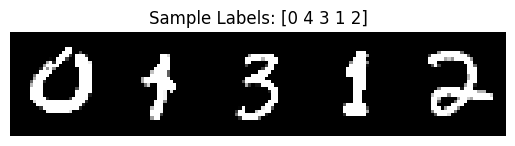

In [8]:
def check_sample(datamodule, batch_size=5):
    # Set to evaluation mode to avoid affecting training
    datamodule.setup('fit')
    
    # Create a DataLoader for the training set
    train_loader = DataLoader(datamodule.train_data, batch_size=batch_size, shuffle=True)
    
    # Get a batch
    images, labels = next(iter(train_loader))
    
    # Print the batch of labels to check digit selection
    print(f"Labels of the sample batch: {labels.numpy()}")
    
    # Plot the images to visually check them
    grid = torchvision.utils.make_grid(images)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert from CxHxW to HxWxC
    plt.title(f"Sample Labels: {labels.numpy()}")
    plt.axis('off')
    plt.show()

# Check a sample before starting the training
check_sample(datamodule)


In [ ]:
# Trainer setup
trainer = Trainer(
    max_epochs=max_epochs,
    logger=tb_logger,
    precision=precision,
    accelerator='auto',
    devices='auto',
    enable_checkpointing=enable_checkpointing,  # Optional: Disable checkpointing for quick runs
    num_sanity_val_steps=num_sanity_val_steps  # Optional: Disables sanity checking
)

# Fit the model
trainer.fit(model, datamodule)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 101 K  | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
C:\Users\NightFore\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Training: |                                                                                      | 0/? [00:00<…

In [ ]:
# Test the model
trainer.test(model, datamodule)